In [157]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import re
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Need a master list of image names and target values

In [158]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20240521/VOOR/05_21_2024_01:35:34_full_VOOR.parquet"
)
df

,valid_time,valid_time_cos,valid_time_sin,target_error,t2m_VOOR,sh2_VOOR,d2m_VOOR,r2_VOOR,u10_VOOR,v10_VOOR,...,relh_SCHO,srad_SCHO,pres_SCHO,mslp_SCHO,wspd_sonic_mean_SCHO,wspd_sonic_SCHO,wmax_sonic_SCHO,wdir_sonic_SCHO,snow_depth_SCHO,precip_total_SCHO
0,2018-01-01 04:00:00,0.999853,0.017166,-0.959006,-19.051306,0.00062,-22.543631,62.599998,-2.098879,0.864037,...,62.572079,0.000000,1013.752991,1015.691467,1.363605,1.527419,3.200459,324.081085,0.052417,0.0
1,2018-01-01 05:00:00,0.999853,0.017166,-0.614071,-19.304892,0.00060,-22.817633,60.700001,-1.915545,1.056595,...,64.739861,0.000015,1013.924011,1015.921875,0.927296,0.835933,2.485592,323.342102,0.053241,0.0
2,2018-01-01 06:00:00,0.999853,0.017166,-0.423907,-19.491537,0.00059,-23.130377,60.299999,-2.284214,1.078495,...,63.690022,0.000025,1014.156982,1016.190979,1.214151,1.270851,3.072864,324.941711,0.055449,0.0
3,2018-01-01 07:00:00,0.999853,0.017166,-0.693755,-19.654745,0.00058,-23.345602,59.599998,-2.082814,1.230507,...,62.971298,0.000000,1014.359009,1016.418274,1.340950,1.066854,3.039994,344.933411,0.055031,0.0
4,2018-01-01 08:00:00,0.999853,0.017166,-0.581839,-19.651419,0.00058,-23.231879,69.599998,-2.231739,-0.083057,...,62.430679,0.000007,1014.208008,1016.265015,1.550128,1.823608,3.847579,319.180786,0.054942,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45372,2023-11-27 19:00:00,0.824855,-0.565345,-0.849863,5.413232,0.00358,-0.962714,63.299999,4.215706,-0.927042,...,53.492821,116.459656,992.622681,993.222534,4.246725,4.677864,7.003131,300.759186,-0.002307,0.0
45373,2023-11-27 20:00:00,0.824855,-0.565345,-0.612452,4.487360,0.00367,-0.587714,67.500000,3.141008,-1.720337,...,54.750111,80.006485,992.903625,993.522217,3.887996,3.082526,6.134368,311.103485,-0.001975,0.0
45374,2023-11-27 21:00:00,0.824855,-0.565345,-0.606020,3.370599,0.00378,-0.150214,74.800003,1.865492,-0.578663,...,57.235580,42.384338,994.077209,994.757202,3.491040,2.510422,5.077372,307.252808,-0.002739,0.0
45375,2023-11-27 22:00:00,0.824855,-0.565345,-1.649844,1.771936,0.00356,-1.025214,73.500000,0.974546,-0.862542,...,60.223789,0.000810,994.563599,995.295044,3.304961,4.489906,6.852775,297.800201,-0.002108,0.0


In [159]:
def re_search(df, var):
    # Use filter to find columns with 'lat' in the name
    _columns = df.filter(regex=re.compile(re.escape(var), re.IGNORECASE)).columns
    df = df[_columns]
    return df

In [160]:
df1 = re_search(df, "t2m")
df1

,t2m_VOOR,t2m_DUAN,t2m_MEDU,t2m_SCHO
0,-19.051306,-22.363806,-20.613806,-19.238806
1,-19.304892,-22.429892,-20.617392,-19.929892
2,-19.491537,-22.366537,-20.554037,-20.304037
3,-19.654745,-22.404745,-20.529745,-21.342245
4,-19.651419,-22.651419,-20.838919,-21.213919
...,...,...,...,...
45372,5.413232,2.163232,3.100732,5.288232
45373,4.487360,1.424860,2.674860,4.612360
45374,3.370599,0.183099,1.433099,3.120599
45375,1.771936,-0.228064,0.084436,2.334436


In [161]:
def inverse_distance_weighting(x, y, z, xi, yi, power=4):
    """
    Interpolates data using Inverse Distance Weighting (IDW).

    Parameters:
    - x: Array of x coordinates (longitudes).
    - y: Array of y coordinates (latitudes).
    - z: Array of values to interpolate (elevations).
    - xi: Array of x coordinates of the interpolation points.
    - yi: Array of y coordinates of the interpolation points.
    - power: Power parameter for IDW. Higher values result in stronger weighting of closer points.

    Returns:
    - zi: Interpolated values at the interpolation points.
    """
    zi = np.zeros_like(xi)

    for i in range(len(xi)):
        distances = np.sqrt((x - xi[i]) ** 2 + (y - yi[i]) ** 2)
        if np.any(distances == 0):
            # If the interpolation point coincides with a data point, use the data point value directly
            zi[i] = z[distances == 0][0]
        else:
            weights = 1 / distances**power
            zi[i] = np.sum(weights * z) / np.sum(weights)

    return zi

In [162]:
def make_dirs(year, month, day):
    if (
        os.path.exists(
            f"/home/aevans/nwp_bias/src/machine_learning/data/images/{year}/"
        )
        == False
    ):
        os.mkdir(f"/home/aevans/nwp_bias/src/machine_learning/data/images/{year}/")
    if (
        os.path.exists(
            f"/home/aevans/nwp_bias/src/machine_learning/data/images/{year}/{month}"
        )
        == False
    ):
        os.mkdir(
            f"/home/aevans/nwp_bias/src/machine_learning/data/images/{year}/{month}"
        )
    if (
        os.path.exists(
            f"/home/aevans/nwp_bias/src/machine_learning/data/images/{year}/{month}/{day}/"
        )
        == False
    ):
        os.mkdir(
            f"/home/aevans/nwp_bias/src/machine_learning/data/images/{year}/{month}/{day}/"
        )


def get_time_title(station):
    today = datetime.now()
    year = today.strftime("%Y")
    month = today.strftime("%m")
    day = today.strftime("%d")
    today_date = today.strftime("%Y%m%d")
    today_date_hr = today.strftime("%Y%m%d_%H:%M")
    make_dirs(year, month, day, today_date, today_date_hr)
    return year, month, day, today_date, today_date_hr

In [163]:
def create_images_interp(df, var):
    valid_time = df["valid_time"].tolist()

    var_df = re_search(df, var)
    lon_df = re_search(df, "lon")
    lat_df = re_search(df, "lat")

    global_min = var_df.min().min()
    global_max = var_df.max().max()

    print(global_min, global_max)

    for t, _ in enumerate(valid_time[:4]):
        lat = []
        lon = []
        var = []
        print(t)
        for c in lat_df.columns:
            lat.append(lat_df[c].iloc[t])

        for c in lon_df.columns:
            lon.append(lon_df[c].iloc[t])

        for c in var_df.columns:
            var.append(var_df[c].iloc[t])

        x, y = np.meshgrid(
            np.linspace(np.min(lon), np.max(lon), 125),
            np.linspace(np.min(lat), np.max(lat), 125),
        )
        xi = x.flatten()
        yi = y.flatten()

        zi = inverse_distance_weighting(lat, lon, var, xi, yi)
        z = zi.reshape(x.shape)

        plt.figure(figsize=(10, 10))
        plt.contourf(x, y, z, cmap="viridis", vmin=global_min, vmax=global_max)
        plt.scatter(lon, lat, c="black", marker="x")
        plt.show()
        # plt.savefig(f'/home/aevans/nwp_bias/src/machine_learning/data/images/{year}/{month}/{day}/{today_date_hr}_{var}.png')

104.88200378417969 417.14898681640625
0


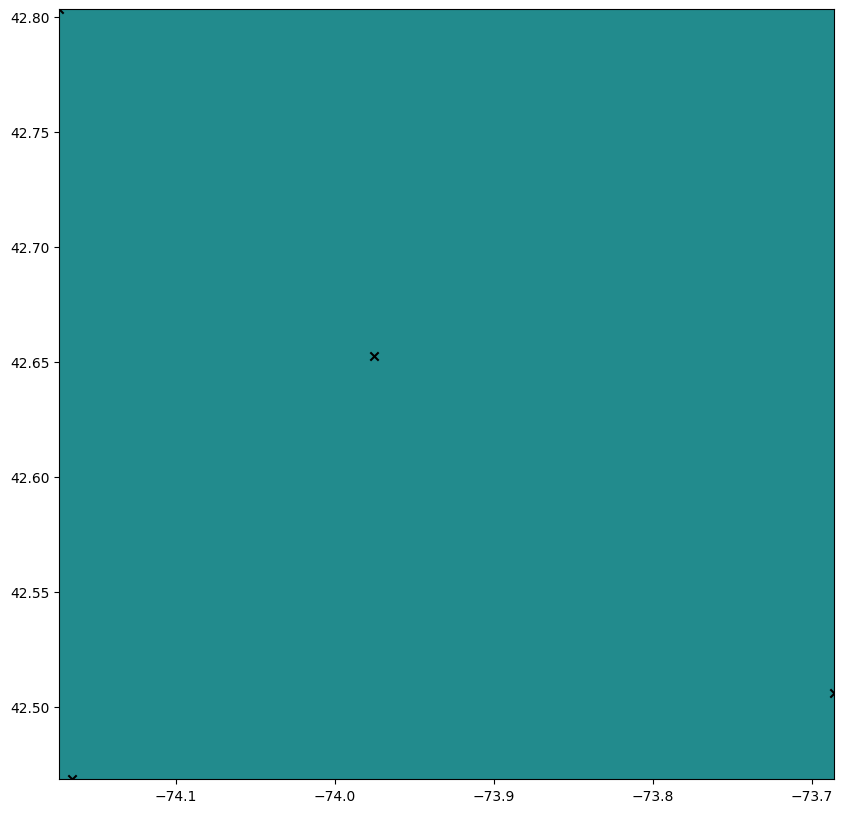

1


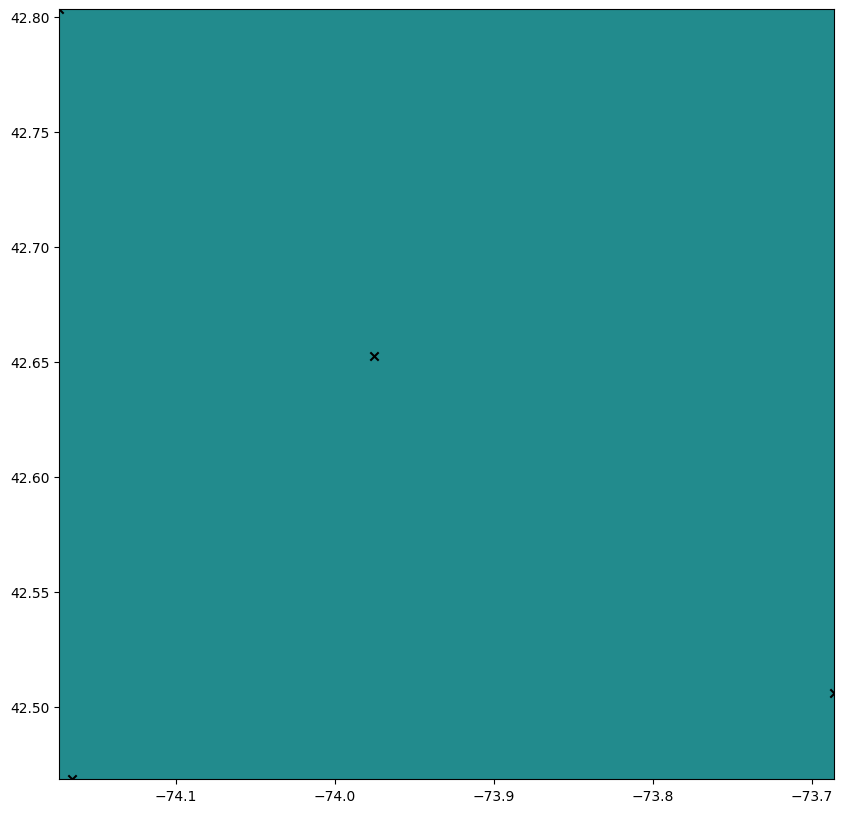

2


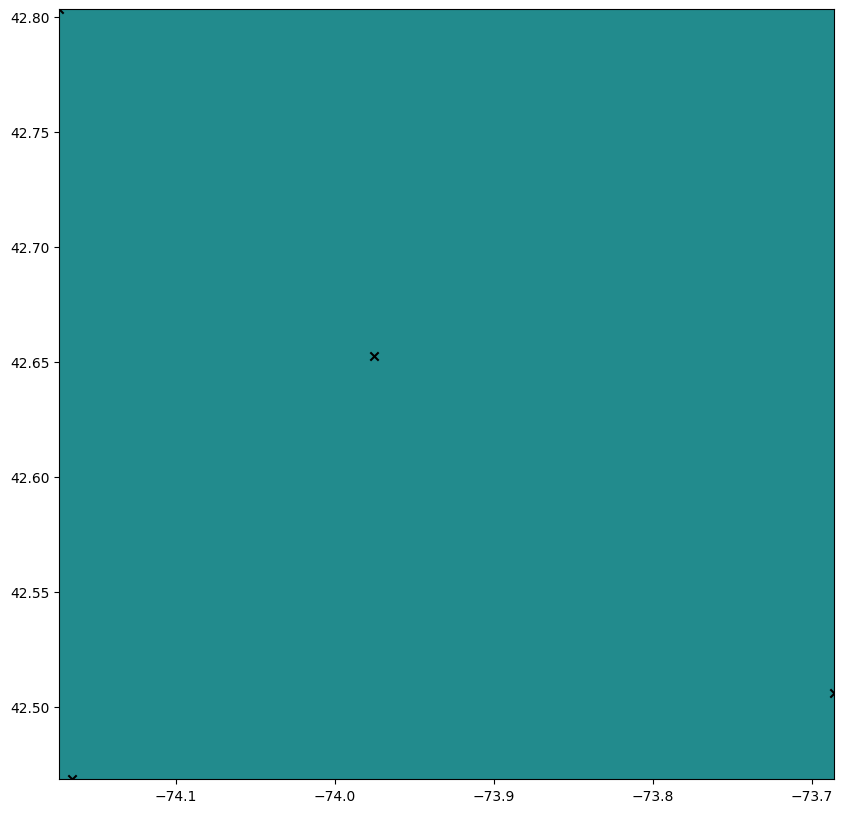

3


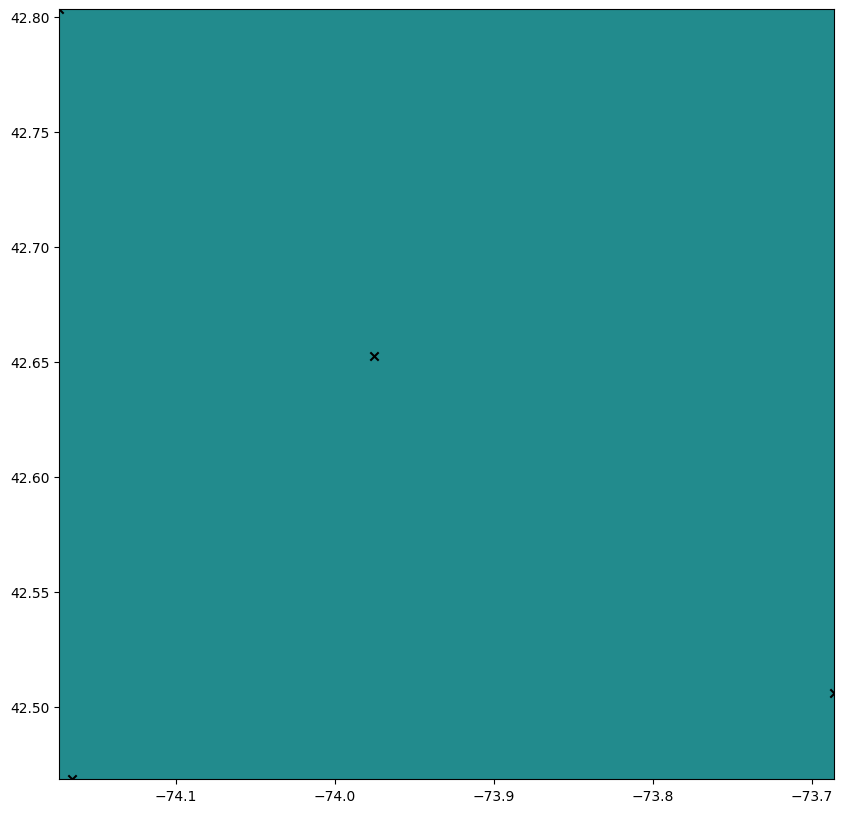

In [164]:
create_images_interp(df, "elev")